In [33]:
# ! pip install newsapi-python

In [1]:
import os

from newsapi import NewsApiClient
from tqdm import tqdm

from keybert import KeyBERT

import pandas as pd
import pickle

from itertools import chain
from collections import Counter

import datetime as DT

In [2]:
# api request를 정하는 부분으로 신중하게 확인할
from_date = '2023-06-06'
to_date = '2023-06-12'
query = '금융 OR 은행 OR 경제 OR 지속가능성'

In [3]:
# 환경 설정
cwd = os.getcwd()
main_path = cwd + '/' + query 

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'dataByDate')

In [4]:
# 데이터 수집(download)

raw = pd.read_excel(main_path + '/' + 'dataByDate/' + 'NewsResult_{}-{}.xlsx'.format(from_date.replace('-',''),to_date.replace('-','')) )

C:\Users\NH\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
dates = [str(x) for x in raw['일자']]
dates = [x[0:4]+'-'+x[4:6]+'-'+x[6:8] for x in dates]
news = raw['본문']
urls =  raw['URL']
keywords = [x.split(',') for x in  raw['특성추출(가중치순 상위 50개)']]

In [6]:
# 정보를 dataframe으로 만들고 저장.
data = pd.DataFrame({'date':dates,'news':news,'url':urls,'keyword':keywords})

name = "dataByDate_{}_{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'dataByDate/' + name,'wb') as f:
    pickle.dump(data,f)

In [7]:
'''
DataCountByDay = data.explode("keyword").reset_index(drop=True)
DataCountByDay = DataCountByDay.groupby(['date','keyword'])['news'].count().reset_index()
DataCountByDayPivot  = pd.pivot_table(DataCountByDay, values='news', index=['date'],
                       columns=['keyword'], aggfunc=np.sum)
DataCountByDayPivot = DataCountByDayPivot.fillna(0)
DataCountByDayPivot = DataCountByDayPivot.T[DataCountByDayPivot.sum(axis = 0) > 30].T
DataCountByDayPivot
'''

'\nDataCountByDay = data.explode("keyword").reset_index(drop=True)\nDataCountByDay = DataCountByDay.groupby([\'date\',\'keyword\'])[\'news\'].count().reset_index()\nDataCountByDayPivot  = pd.pivot_table(DataCountByDay, values=\'news\', index=[\'date\'],\n                       columns=[\'keyword\'], aggfunc=np.sum)\nDataCountByDayPivot = DataCountByDayPivot.fillna(0)\nDataCountByDayPivot = DataCountByDayPivot.T[DataCountByDayPivot.sum(axis = 0) > 30].T\nDataCountByDayPivot\n'

In [8]:
# 키워드 카운트
DataCountByDay = pd.DataFrame(Counter(list(chain(*data['keyword'].values))),index = [from_date])

In [9]:
DataCountByDay = DataCountByDay.T

In [10]:
# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from wordcloud import (WordCloud, get_single_color_func)
import numpy as np
def DrawPointColoredWC(tags,title,cwd,searching_word, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + searching_word + '/'+ title + ' 강조'+'.pdf')
    plt.show()
    
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [11]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'본부장','시간date','a씨','1만','한국','이재명','홈페이지','대통령실','1조','가능성','대한민국','서울','관계자','위원회','만큼','윤석열','민주당','더불어민주당','전문가','연구원','우리나라','위원장']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

In [12]:
'''
DataCountByDay = DataCountByDay.T
DataCountByDay['digital'] = 16
DataCountByDay['supply chain'] = 18
DataCountByDay = DataCountByDay.T
'''

"\nDataCountByDay = DataCountByDay.T\nDataCountByDay['digital'] = 16\nDataCountByDay['supply chain'] = 18\nDataCountByDay = DataCountByDay.T\n"

2023-06-06에서 2023-06-12까지 키워드 출현 빈도 순 상위 50개 입니다


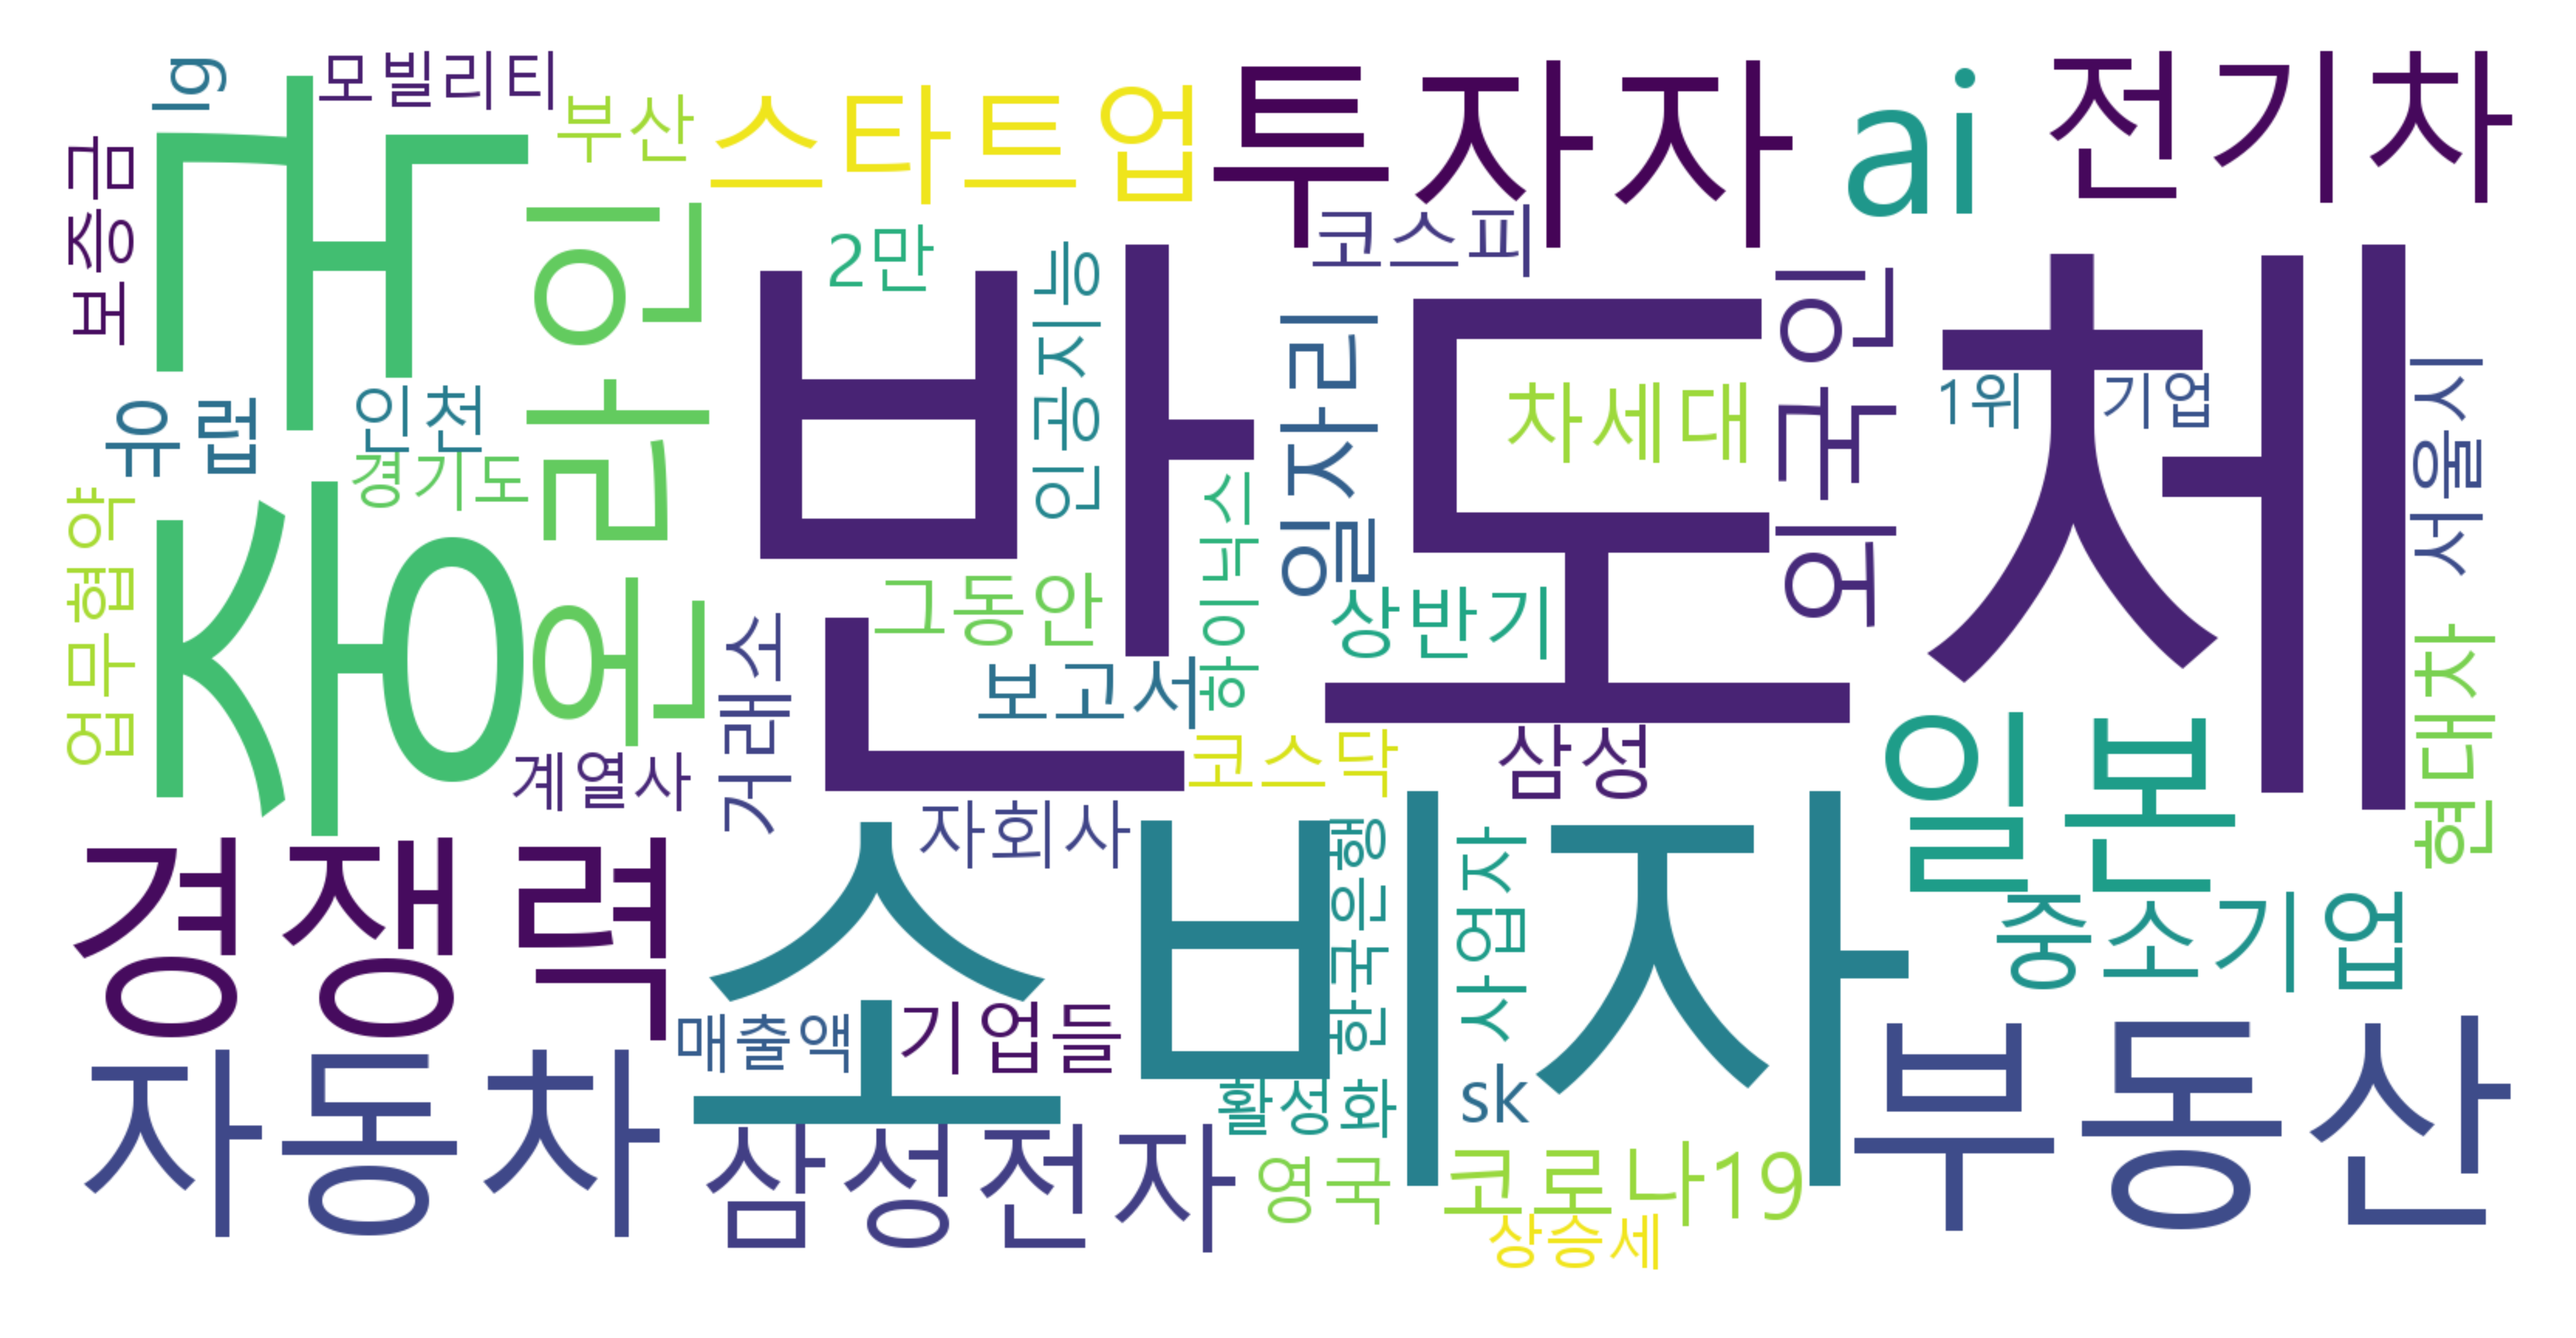

In [13]:
# 그림 그리기 및 저장
tags = DataCountByDay.sort_values(by = from_date, ascending = False)[1:num+1][from_date]
tags = tags.drop(drop_list, errors = 'ignore')[:num_exp]
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = '대상기간_최대출현_키워드_{}개'.format(str(len(tags)))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + query + '/'+ title + from_date + '.pdf')
plt.show()